# Masks on k-space

We design disk shaped masks for 2d and 3d k-spaces.

In [1]:
import torch
from torch.fft import fftn, fft2, fftshift, ifftshift, ifft2, ifftn

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fourier transform

## Constant value

In [376]:
x = torch.ones(3,3)
# Fourier transformed
k = fftn(x)
# shifted k
k_shifted = fftshift(k)

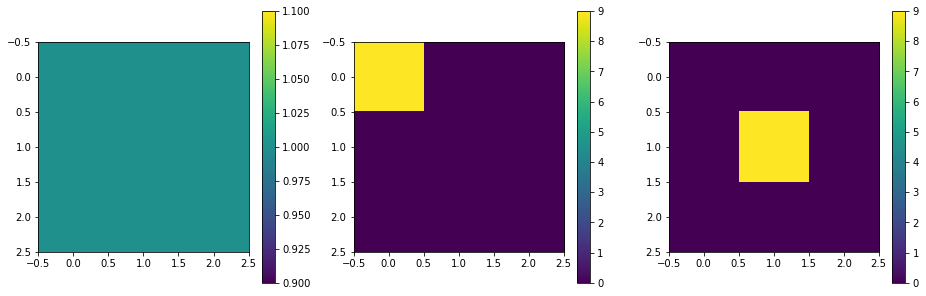

In [19]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.imshow(x)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(k.abs())
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(k_shifted.abs())
plt.colorbar()

In [43]:
k

tensor([[9.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]])

In [44]:
fftshift(k)

tensor([[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 9.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]])

## Stripes

In [21]:
x = torch.tensor([1,1,0,0]).repeat(2)
x = x.repeat(len(x),1)
x

k = fftn(x)
k_shifted = fftshift(k)

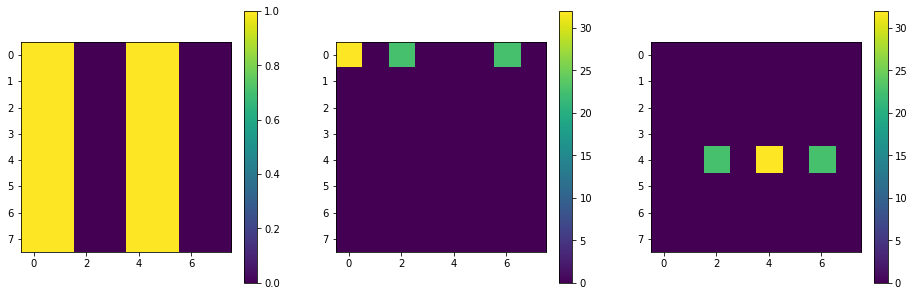

In [22]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.imshow(x)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(k.abs())
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(k_shifted.abs())
plt.colorbar()

In [52]:
k

tensor([[32.+0.j,  0.+0.j, 16.-16.j,  0.+0.j,  0.+0.j,  0.+0.j, 16.+16.j,
          0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
          0.+0.j]])

## Complex image

In [3]:
def show(img: torch.Tensor
         ) -> None:
    img = img.clone()
    min, max = img.min(), img.max()
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max-min+1e-5)
    
    plt.imshow(img.permute(1, 2, 0))

def show_2d(img: torch.Tensor
         ) -> None:
    img = img.clone()
    min, max = img.min(), img.max()
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max-min+1e-5)
    
    plt.imshow(img)

In [4]:
# load image
lena_set = ImageFolder('/content/drive/MyDrive/lena_folder/', transform=ToTensor())
img = lena_set[0][0]

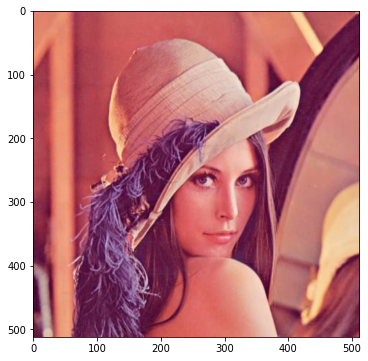

In [5]:
# show image
plt.figure(figsize=(6,6))
plt.imshow(img.permute(1,2,0))
plt.show()

In [11]:
# Fourier and shift
k = fft2(img)
k_shifted = fftshift(k,dim=(1,2))

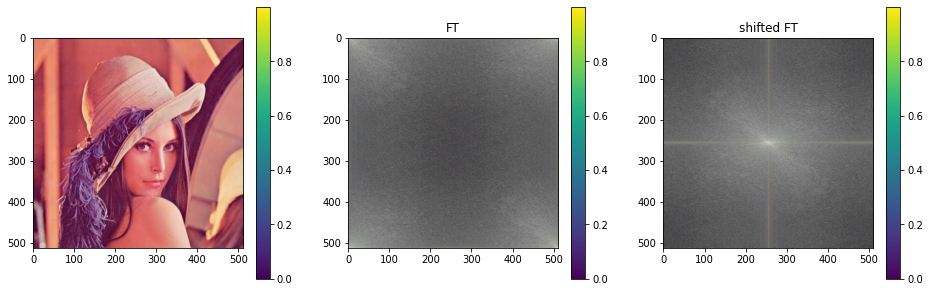

In [12]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
show(img)
plt.colorbar()

plt.subplot(1,3,2)
show(k.abs().log())
plt.title('FT')
plt.colorbar()

plt.subplot(1,3,3)
show(k_shifted.abs().log())
plt.colorbar()
plt.title('shifted FT')
plt.show()

In [8]:
# working with one channel
k = fft2(img[0])
k_shifted = fftshift(k)

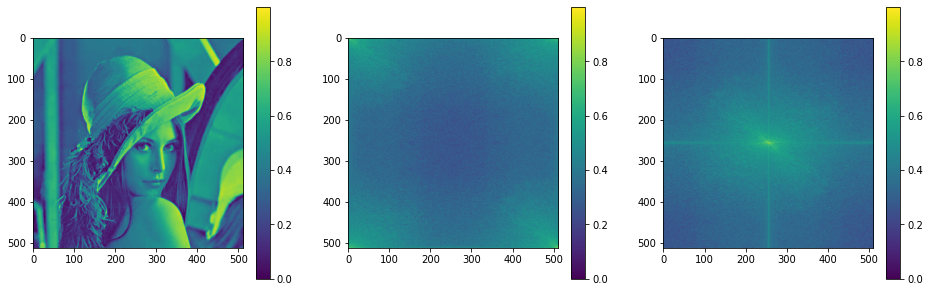

In [9]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
show_2d(img[1])
plt.colorbar()

plt.subplot(1,3,2)
show_2d(k.abs().log())
plt.colorbar()

plt.subplot(1,3,3)
show_2d(k_shifted.abs().log())
plt.colorbar()

# Masks in k-space

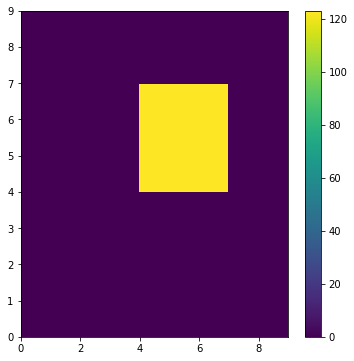

In [51]:
# Steps ot create a circular mask

x = np.arange(0, 10)
y = np.arange(0, 10)
arr = np.zeros((y.size, x.size))

cx = 5.
cy = 5.
r = 2.

# The two lines below could be merged, but I stored the mask
# for code clarity.
mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
arr[mask] = 123.

# This plot shows that only within the circle the value is set to 123.
plt.figure(figsize=(6, 6))
plt.pcolormesh(x, y, arr)
plt.colorbar()
plt.show()

In [250]:
# Code to design circular masks in 2d and 3d, allowing for 
# channel/batch dimensions.

from math import floor

class disk_mask():
    '''
    Class to generate and apply mask with a circular boundary.
    
    It assumes last two dimensions are equal.
    '''

    def __init__(self, k_tensor:torch.tensor, r:int = 2, dim:int=2,
                 inside_off=True):

        '''
        Args:
        k_tensor[torch.tensor] = image in k space.
        r[int] = radius for mask.
        dim[int] = dimension of image (2 or 3).
        inside_off[boolean] = set True to mask radius < r,
                           set False to mask radius > r. 
        '''


        self.r = r
        self.dim = dim
        self.inside_off = inside_off
        self.last_dims = k_tensor.size(-1)
        
        if self.dim == 2:
            self.binary_mask = self.binary_mask_2d(k_tensor)
        elif self.dim == 3:
            self.binary_mask = self.binary_mask_3d(k_tensor)
        else:
            print('Only 2- and 3-dimensional images.')


    def binary_mask_2d(self, k_tensor) -> torch.tensor:
        '''To build a 2d mask using the last two dimensions'''

        # instatiate mask holder array and reshape to (bunch,H,W)
        mask = torch.zeros(k_tensor.size())
        mask = mask.reshape(-1,k_tensor.size(-2), k_tensor.size(-1))

        # create boolean disk centered at image's center, and
        # with given radius
        center = (floor(k_tensor.size(-2) / 2),
                  floor(k_tensor.size(-1) / 2))
        
        axes = (torch.arange(0, k_tensor.size(-2)),
                torch.arange(0, k_tensor.size(-1)))
        
        select = ( (axes[0][:,None] - center[0])**2 + 
                   (axis[1][None,:] - center[1])**2 ) < self.r**2
                   
        # add batch dimensions
        select = select.unsqueeze(0).repeat_interleave(mask.size(0),0)

        # create binary mask
        mask[select] = 1
        if self.inside_off:
            mask = 1 - mask
        mask = mask.reshape(k_tensor.size())
        return mask

    
    def binary_mask_3d(self, k_tensor) -> torch.tensor:
        '''To build a 3d mask using the last three dimensions '''

        # instatiate mask holder array and reshape to (bunch,H,W)
        mask = torch.zeros(k_tensor.size())
        mask = mask.reshape(-1, k_tensor.size(-3), 
                                k_tensor.size(-2), 
                                k_tensor.size(-1))
        
        # create boolean disk centered at image's center, and
        # with given radius
        center = (floor(k_tensor.size(-3) / 2),
                  floor(k_tensor.size(-2) / 2),
                  floor(k_tensor.size(-1) / 2))
        
        axes = (torch.arange(0, k_tensor.size(-3)),
                torch.arange(0, k_tensor.size(-2)),
                torch.arange(0, k_tensor.size(-1)))   
                
        select = ( (axes[0][:,None,None] - center[0])**2 + 
                   (axes[1][None,:,None] - center[1])**2 + 
                   (axes[2][None,None,:] - center[2])**2 
                  ) < self.r**2

        # add batch dimensions
        select = select.unsqueeze(0).repeat_interleave(mask.size(0),0)

        # create binary mask
        mask[select] = 1
        if self.inside_off:
            mask = 1 - mask
        mask = mask.reshape(k_tensor.size())
        return mask


    def apply(self, k_tensor:torch.tensor) -> torch.tensor:
        '''Apply obtained mask on given tensor'''

        assert k_tensor.size(-1) == self.last_dims, f'Last dimension of input \
                                must be = {self.last_dims}'

        return k_tensor * self.binary_mask



## Working with 2d images

### Masking high frequencies

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


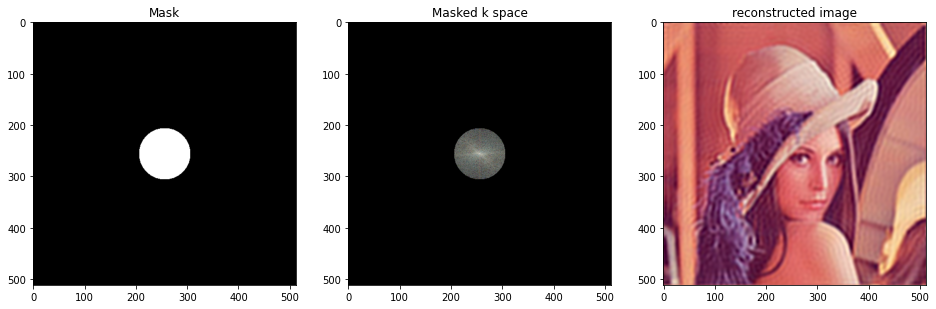

In [76]:
m = disk_mask(k_shifted.abs().log(),r=50, inside_off=False)
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.imshow(m.binary_mask.permute(1,2,0))
plt.title('Mask')


k_shifted_2 = m.apply(k_shifted)

plt.subplot(1,3,2)
show(m.apply(k_shifted.abs().log()))
plt.title('Masked k space')


k_2 = ifftshift(k_shifted_2,dim=(1,2))
img_r = ifft2(k_2)

plt.subplot(1,3,3)
plt.title('reconstructed image')
plt.imshow(img_r.permute(1,2,0).real)
plt.show()

### Masking out low frequencies

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


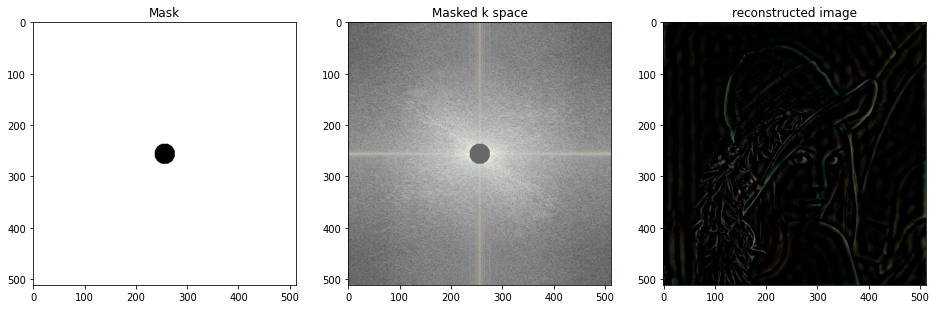

In [402]:
m = disk_mask(k_shifted.abs().log(),r=20, inside_off=True)
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.imshow(m.binary_mask.permute(1,2,0))
plt.title('Mask')


k_shifted_2 = m.apply(k_shifted)

plt.subplot(1,3,2)
show(m.apply(k_shifted.abs().log()))
plt.title('Masked k space')


k_2 = ifftshift(k_shifted_2,dim=(1,2))
img_r = ifft2(k_2)

plt.subplot(1,3,3)
plt.title('reconstructed image')
plt.imshow(img_r.permute(1,2,0).real)
plt.show()

## Working with 3d images

In [251]:
# install the latest weekly preview version of MONAI
%pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]" > log.log

In [252]:
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)

In [253]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

xform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image","label"], roi_size=[128, 128, 64]), 
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)


In [254]:
data = xform({'image':'/content/drive/MyDrive/51_MONAI/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz',
              'label':'/content/drive/MyDrive/51_MONAI/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz'})

In [232]:
data['image_meta_dict']

{'affine': array([[1.5, 0. , 0. , 0. ],
        [0. , 1.5, 0. , 0. ],
        [0. , 0. , 2. , 0. ],
        [0. , 0. , 0. , 1. ]]),
 'as_closest_canonical': False,
 'bitpix': array(32, dtype=int16),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'datatype': array(16, dtype=int16),
 'dim': array([  4, 240, 240, 155,   4,   1,   1,   1], dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'extents': array(0, dtype=int32),
 'filename_or_obj': '/content/drive/MyDrive/51_MONAI/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz',
 'glmax': array(0, dtype=int32),
 'glmin': array(0, dtype=int32),
 'intent_code': array(0, dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'original_affine': array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 'original_channel_dim': -1,
 'pixdim': array([1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32),
 

In [233]:
img_3d = data['image']
label = data['label']
print(img_3d.size())
print(label.size())

torch.Size([4, 128, 128, 64])
torch.Size([3, 128, 128, 64])


In [234]:
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

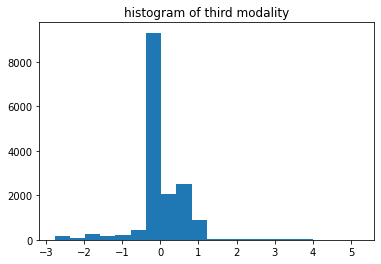

In [245]:
plt.hist(img_3d[2,:,:,32].flatten(),bins=20)
plt.title('histogram of third modality')
plt.show()

In [236]:
# Fourier and shift
img_f = fftn(img_3d, dim=(1,2,3))
img_fs = fftshift(img_f,dim=(1,2,3))

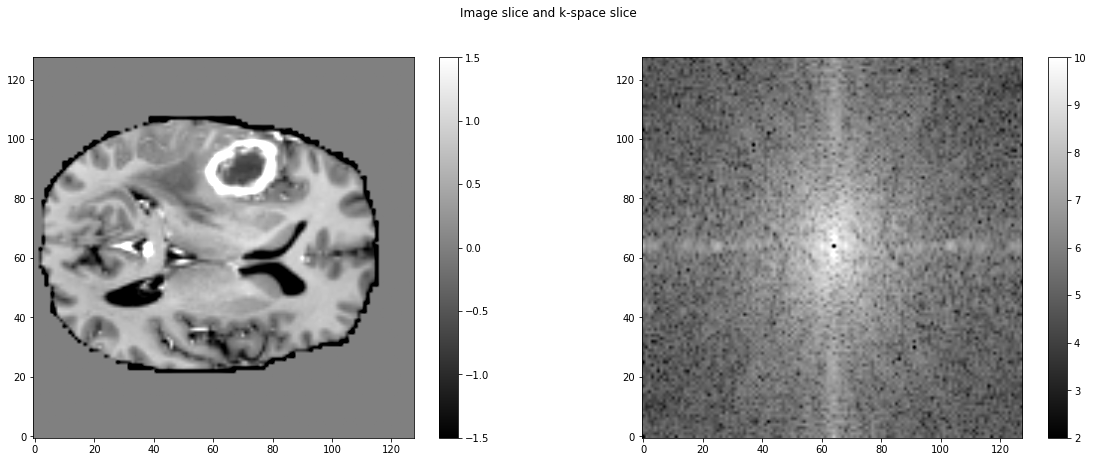

In [244]:
# Display image and shifted FT

low, high = wl_to_lh(window=3, level=0) # set using histogram

plt.figure(figsize=(20,7))
plt.suptitle('Image slice and k-space slice')
plt.subplot(1,2,1)
plt.imshow(img_3d[2,:,:,32],cmap='gray', vmin=low, vmax=high, 
           interpolation='bilinear', origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
low_f, high_f = wl_to_lh(8,6)
plt.imshow(img_fs.abs().log()[2,:,:,32], cmap='gray', vmin=low_f, vmax=high_f, 
           interpolation='bilinear', origin='lower')
plt.colorbar()
plt.show()

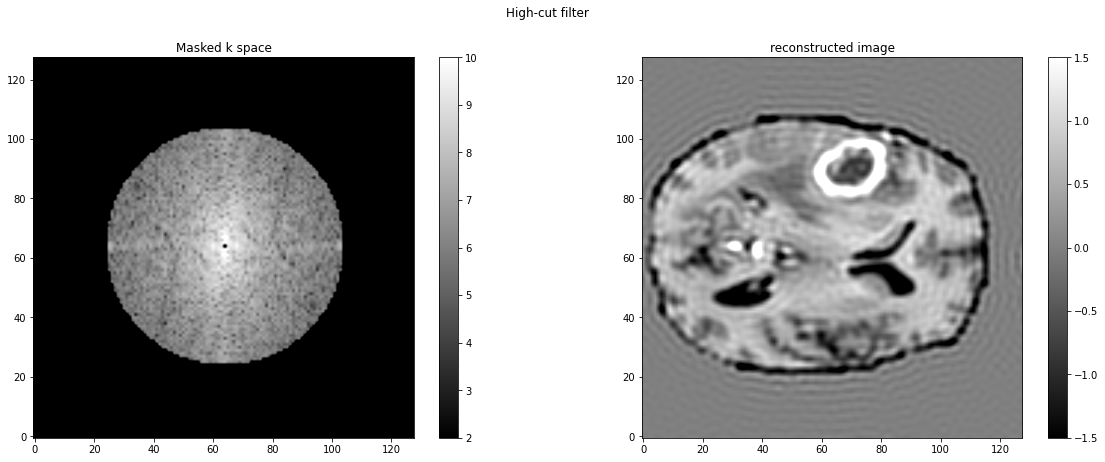

In [243]:
# Display masked FT and reconstruction

m_3d = disk_mask(img_fs.abs().log(),r=40, dim=3,inside_off=False)
img_fs_2 = m_3d.apply(img_fs)

plt.figure(figsize=(20,7))
plt.suptitle('High-cut filter')
plt.subplot(1,2,1)
plt.imshow(m_3d.apply(img_fs.abs().log())[2,:,:,32], cmap='gray', 
           vmin=low_f,vmax=high_f,interpolation='bilinear', origin='lower')
plt.title('Masked k space')
plt.colorbar()

img_r = ifftn(ifftshift(img_fs_2,dim=(1,2,3)), 
              dim=(1,2,3))

plt.subplot(1,2,2)
plt.title('reconstructed image')
plt.imshow(img_r[2,:,:,32].real, cmap='gray', vmin=low, vmax=high, 
           interpolation='bilinear', origin='lower')
plt.colorbar()
plt.show()

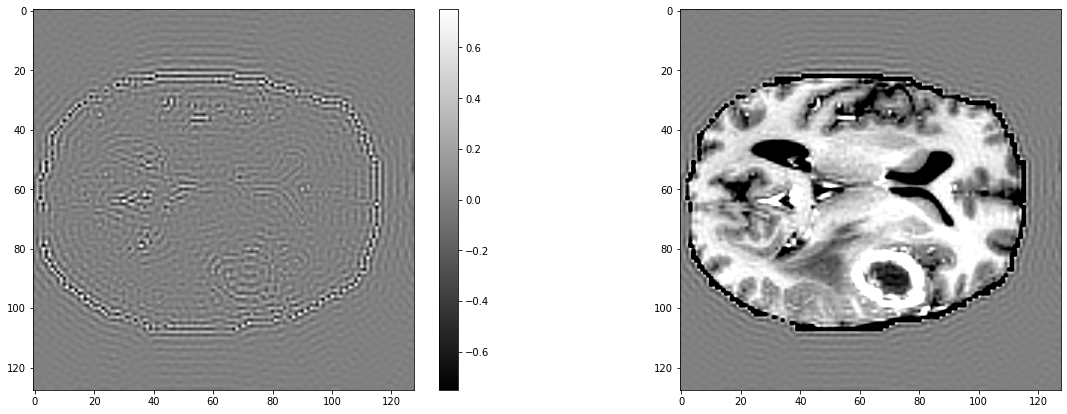

In [133]:
# adding waves to original image ?

waves = img_3d[2,:,:,32]- img_r[2,:,:,32].real

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.imshow(waves, cmap='gray', vmin=-.75, vmax=.75, interpolation='bilinear')
plt.colorbar()

img_3d_higher = img_3d[2,:,:,32] + waves
plt.subplot(1,2,2)
plt.imshow( img_3d_higher, cmap='gray', vmin=-.9, vmax=.9, interpolation='bilinear')


## Adding plane waves

In [237]:
# Fourier and shift
img_f = fftn(img_3d, dim=(1,2,3))
img_fs = fftshift(img_f,dim=(1,2,3))

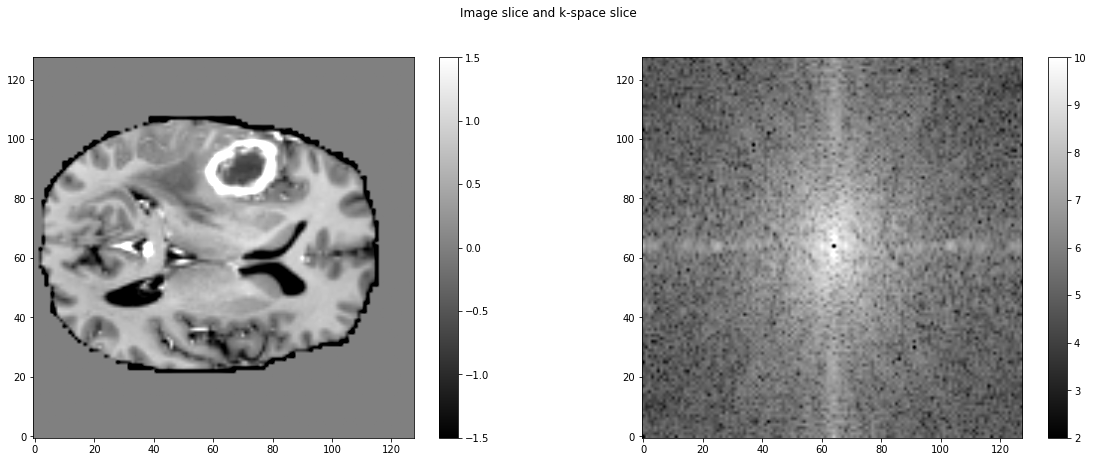

In [242]:
# Display image and shifted FT

plt.figure(figsize=(20,7))
plt.suptitle('Image slice and k-space slice')
plt.subplot(1,2,1)
plt.imshow(img_3d[2,:,:,32],cmap='gray', vmin=low, vmax=high, 
           interpolation='bilinear', origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
low_f, high_f = wl_to_lh(8,6)
plt.imshow(img_fs.abs().log()[2,:,:,32], cmap='gray', vmin=low_f, vmax=high_f, 
           interpolation='bilinear', origin='lower')
plt.colorbar()
plt.show()

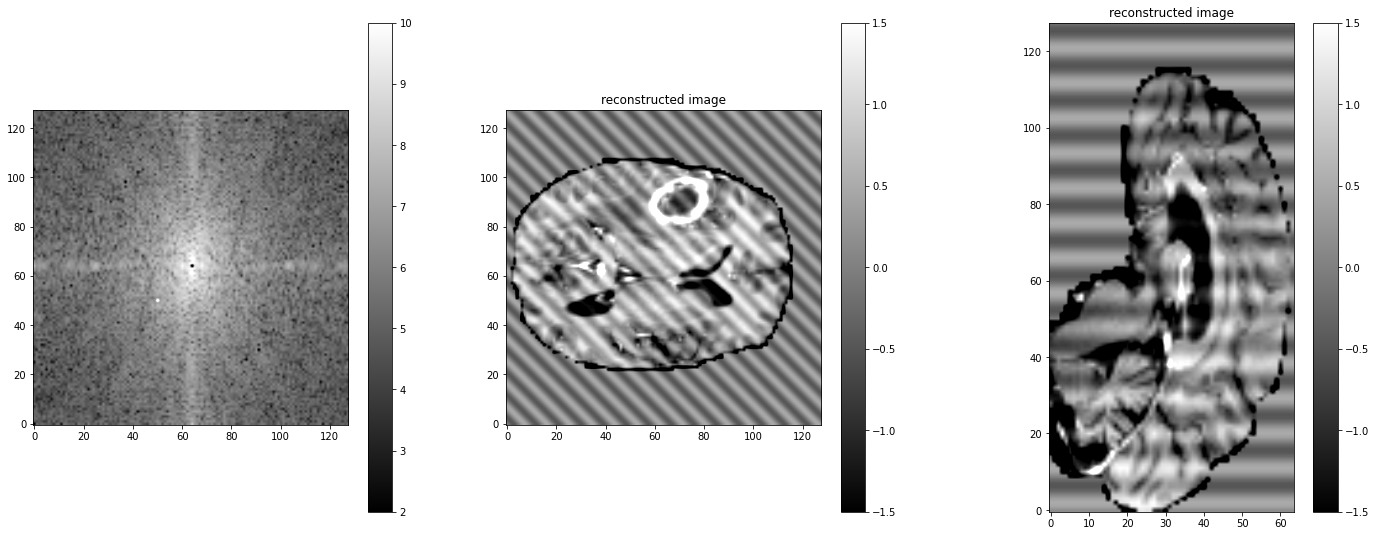

In [241]:
BRIGHT_FACTOR = 500
PX, PY = 50, 50
img_fs_bright_pixel = img_fs.clone()
img_fs_bright_pixel[2,PX,PY,32] = img_fs_bright_pixel[2,PX,PY,32]*BRIGHT_FACTOR

plt.figure(figsize=(24,9))
plt.subplot(1,3,1)
plt.imshow(img_fs_bright_pixel.abs().log()[2,:,:,32], cmap='gray', 
           vmin=low_f, vmax=high_f, interpolation='bilinear', origin='lower')
plt.colorbar()

# inverse transform
img_r_planar = ifftn(ifftshift(img_fs_bright_pixel,dim=(1,2,3)), 
              dim=(1,2,3))

plt.subplot(1,3,2)
plt.title('reconstructed image')
plt.imshow(img_r_planar[2,:,:,32].real, cmap='gray', vmin=low, vmax=high, 
           origin='lower', interpolation='bilinear')
plt.colorbar()


# plot reconstructed image
plt.subplot(1,3,3)
plt.title('reconstructed image')
plt.imshow(img_r_planar[2,60,:,:].real, cmap='gray', vmin=low, vmax=high, 
           origin='lower', interpolation='bilinear')
plt.colorbar()
plt.show()


## aliasing

In [256]:
# Fourier and shift
img_f = fftn(img_3d, dim=(1,2,3))
img_fs = fftshift(img_f,dim=(1,2,3))

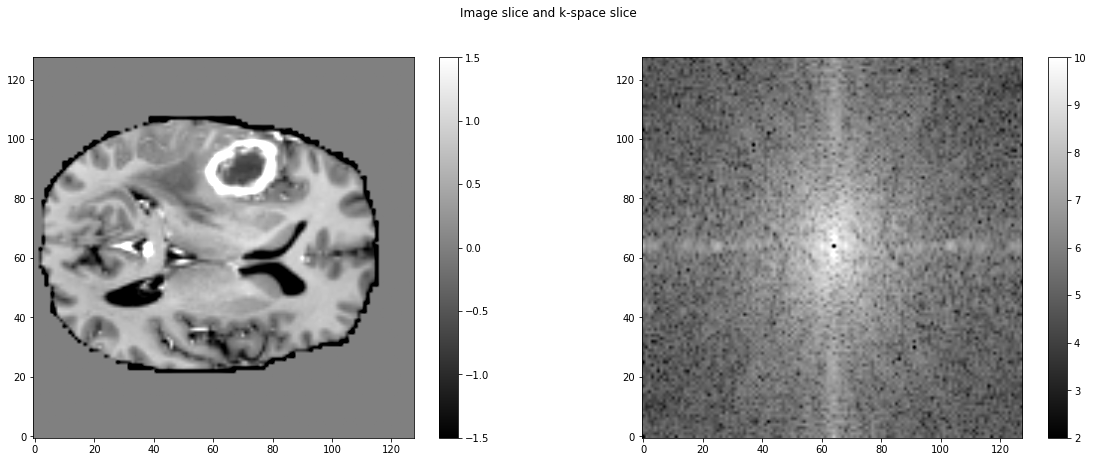

In [257]:
# Display image and shifted FT

low, high = wl_to_lh(window=3, level=0) # set using histogram

plt.figure(figsize=(20,7))
plt.suptitle('Image slice and k-space slice')
plt.subplot(1,2,1)
plt.imshow(img_3d[2,:,:,32],cmap='gray', vmin=low, vmax=high, 
           interpolation='bilinear', origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
low_f, high_f = wl_to_lh(8,6)
plt.imshow(img_fs.abs().log()[2,:,:,32], cmap='gray', vmin=low_f, vmax=high_f, 
           interpolation='bilinear', origin='lower')
plt.colorbar()
plt.show()

In [263]:
img_fs.size()

torch.Size([4, 128, 128, 64])

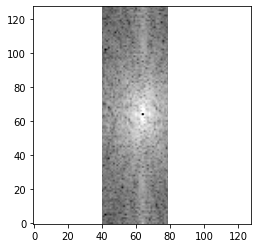

In [311]:
img_fs_slice = img_fs[2,:,:,:].clone().unsqueeze(0)
img_fs_slice[:,:,0:40,:]=0
img_fs_slice[:,:,80:130,:]=0

plt.imshow(img_fs_slice.abs().log()[0,:,:,32], cmap='gray', 
           vmin=low_f, vmax=high_f, interpolation='bilinear', origin='lower')
plt.show()

In [312]:
# inverse transform
img_r_sample = ifftn(ifftshift(img_fs_slice,dim=(1,2,3)), 
              dim=(1,2,3))

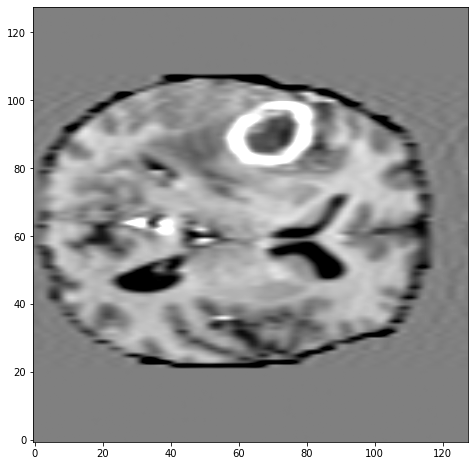

In [313]:
plt.figure(figsize=(8,8))
plt.imshow(img_r_sample[0,:,:,32].real,cmap='gray', vmin=low, vmax=high, 
           interpolation='bilinear', origin='lower')

# Contrast filter

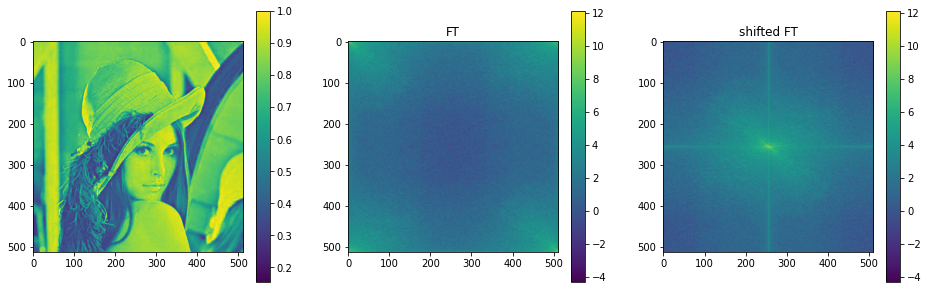

In [133]:
img = lena_set[0][0][0]

# Fourier and shift
k = fft2(img)
k_shifted = fftshift(k)

plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(k.abs().log())
plt.title('FT')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(k_shifted.abs().log())
plt.colorbar()
plt.title('shifted FT')
plt.show()

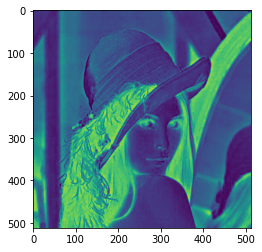

In [134]:
k_mult = k*-1
img_r = ifft2(k_mult)
plt.imshow(img_r.real)